# Lens Modeling for DESIJ1101-0602

Authors: S M Rafee Adnan, Janntul Feardous, Anowar J. Shajib


Acknowledgement: Sulyman Hossain

In [291]:
import corner

# import of standard python libraries
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q, shear_cartesian2polar
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Loading Data from h5 Files

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/794900251.py:10: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


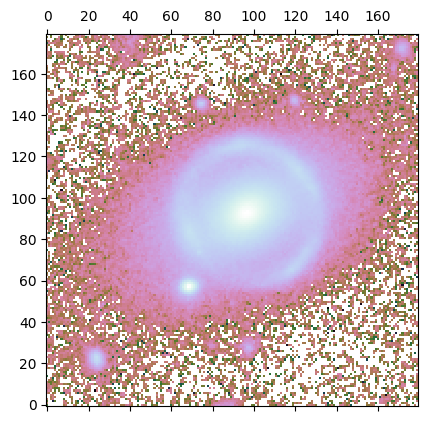

In [292]:
# data specifics

with h5py.File("DESIJ1101-0602_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]
kwargs_data
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

In [293]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [294]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
# beta, n_max, center_x, center_y
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/457118268.py:125: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/457118268.py:125: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


Text(0.5, 1.0, 'IMAGE AFTER MASKING')

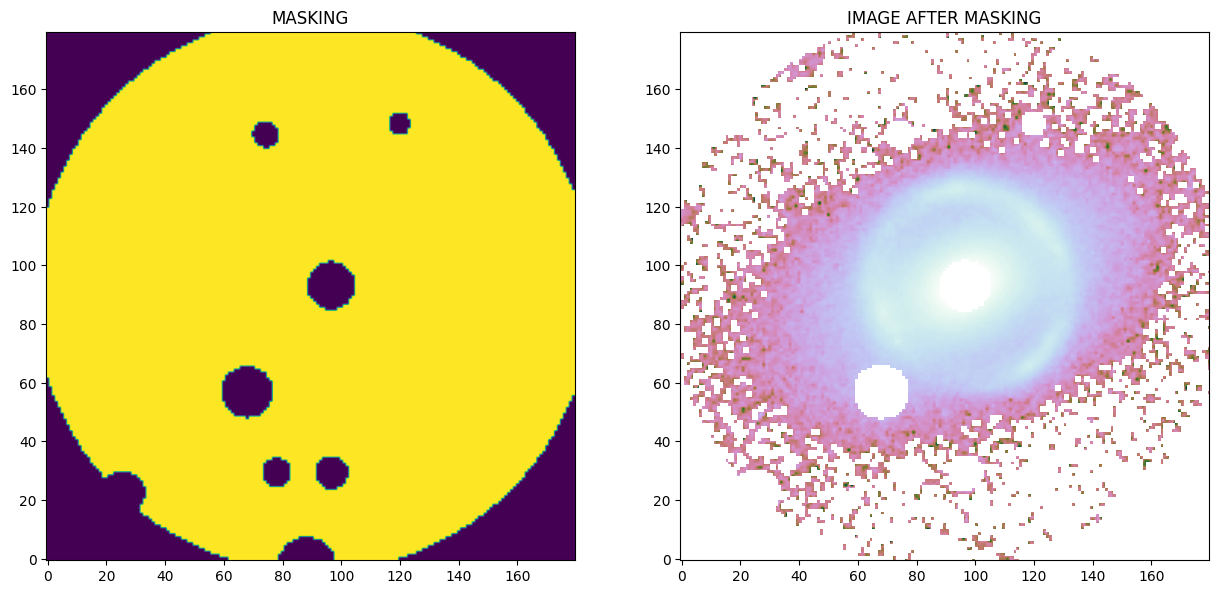

In [295]:
# To make a mask using lenstronomy functions:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 7.6  # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec - 2.7,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_ext_6 = mask_util.mask_ellipse(    # Central Mask
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.4828,
    lens_center_dec + 0.1960,
    0.65,
    0.65,
    0,
)

mask_ext_7 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 5.1828,
    lens_center_dec - 5.460,
    0.6,
    0.6,
    0,
)

mask_ext_8 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.1828,
    lens_center_dec - 7.460,
    0.8,
    0.8,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1)
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3) *(1 - mask_ext_8) 
mask_3 = (1 - mask_ext_4) * (1 - mask_ext_5) * (1 - mask_ext_6) *(1 - mask_ext_7) 
mask1 = mask_1 * mask_2 * mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0


mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")


plt.sca(axs[1])
plt.imshow(image, origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")

In [296]:
# lens galaxy's mass model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Setting EPL Parameters

fixed_lens.append({"gamma": 2.0})
kwargs_lens_init.append(
    {
        "theta_E": 2.6184,
        "gamma": 2.0,
        "e1": 0.1388,
        "e2": -0.1405,
        "center_x": -0.4901,
        "center_y": 0.2286,
    }
)
kwargs_lens_sigma.append(
    {
        "gamma": 0.1,
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
    }
)
kwargs_lower_lens.append(
    {
        "gamma": 1.9,
        "theta_E": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "gamma": 3.0,
        "theta_E": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


# Setting SHEAR Parameters

fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.0377, "gamma2": -0.0086})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

In [297]:
# lens galaxy's light model


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})

kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 0.6110,
        "n_sersic": 1.2349,
        "e1": 0.1540,
        "e2": -0.1657,
        "center_x": -0.4801,
        "center_y": 0.1970,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 5.0,
        "n_sersic": 6.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# sersic_2


fixed_lens_light.append({})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 2.0587,
        "n_sersic": 0.7722,
        "e1": 0.1540,
        "e2": -0.1657,
        "center_x": -0.4801,
        "center_y": 0.1970,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 5.0,
        "n_sersic": 6.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [298]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "amp": 1,
        "R_sersic": 0.1767,
        "n_sersic": 1.0,
        "e1": 0.3748,
        "e2": 0.1039,
        "center_x": -0.5978,
        "center_y": 0.1746,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.008,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.3,
        "n_sersic": 2.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# add shapelets model to this source model
fixed_source.append({"n_max": 8})
kwargs_source_init.append(
    {"beta": 0.1470, "center_x": -0.5978, "center_y": 0.1746}
)
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.1, "center_y": 0.1})
kwargs_lower_source.append({"beta": 0.03, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

joint_source_with_shapelet = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

In [299]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_shapelet,
}
kwargs_likelihood = {
    "check_bounds": True,
    "image_likelihood_mask_list": [mask_img],
    "check_positive_flux": True,
}

kwargs_numerics = {
    "supersampling_factor": 3,
    "supersampling_convolution": False,
}
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [
    [
        kwargs_data,
        kwargs_psf,
        kwargs_numerics,
    ]
]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## PSO: Model Fitting

In [275]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 200}]
]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.696135198761334 reduced X^2 of best position
-9229.708532777147 log likelihood
26517 effective number of data points
[{'theta_E': 2.618463825717177, 'gamma': 2.0, 'e1': 0.1388256335707308, 'e2': -0.14054141383289012, 'center_x': -0.49018260564768373, 'center_y': 0.22861697135320863}, {'gamma1': 0.03774858243547512, 'gamma2': -0.008683020585243282, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.17677175618324859, 'n_sersic': 1.0, 'e1': 0.3748787849705812, 'e2': 0.10392562970982665, 'center_x': -0.5978470247931734, 'center_y': 0.1746245948333779}, {'amp': 1, 'n_max': 8, 'beta': 0.14707245896659776, 'center_x': -0.5978470247931734, 'center_y': 0.1746245948333779}] source result
[{'amp': 1, 'R_sersic': 0.6110979889553925, 'n_sersic': 1.23495234181962, 'e1': 0.15402120369325933, 'e2': -0.16579956672908408, 'center_x': -0.48016805651295813, 'center_y

In [276]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1101-0602_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

-0.6943284833373453 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6943284833373643


/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


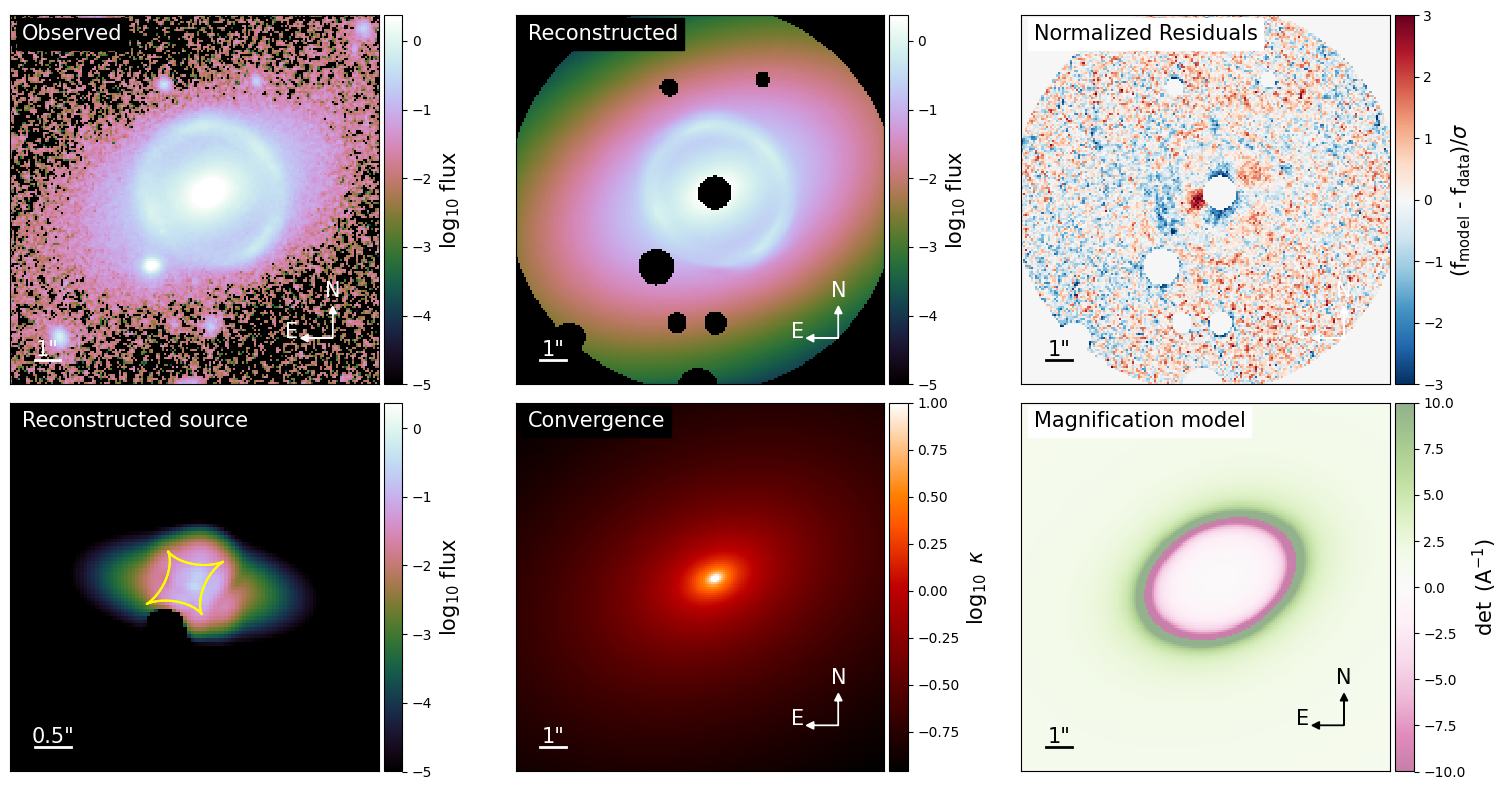

/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


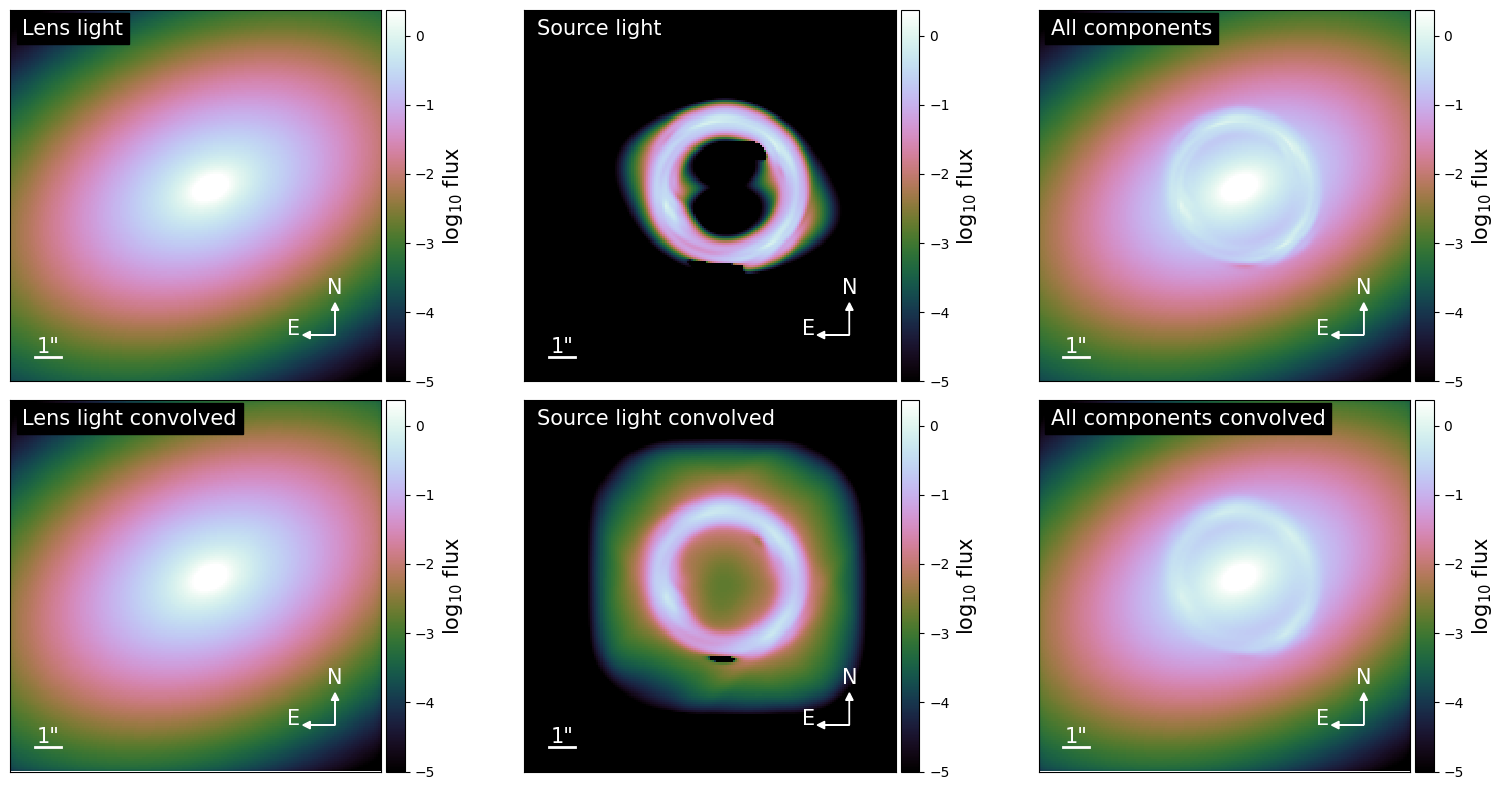

{'kwargs_lens': [{'theta_E': 2.618463825717177, 'gamma': 2.0, 'e1': 0.1388256335707308, 'e2': -0.14054141383289012, 'center_x': -0.49018260564768373, 'center_y': 0.22861697135320863}, {'gamma1': 0.03774858243547512, 'gamma2': -0.008683020585243282, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 33.84569235660566, 'R_sersic': 0.17677175618324859, 'n_sersic': 1.0, 'e1': 0.3748787849705812, 'e2': 0.10392562970982665, 'center_x': -0.5978470247931734, 'center_y': 0.1746245948333779}, {'amp': array([ 41.53784205, -24.48564069,  22.58856361,  15.07307988,
       -22.21698123,  92.30863681,  -1.2315764 ,  -7.69403523,
        -5.05517689,   4.09308139,  13.3000109 ,  -9.13132038,
        18.67182524,   9.33480462,  -2.06813001,  -5.68911286,
         9.42734623,   4.8612819 ,   7.24150025,  -9.38031871,
         8.21176559,  -5.99164647,  -8.48317828,   2.56206238,
         5.85465539,   0.57231109,   1.68117287,  21.27250228,
         8.90854345,  -4.39266193,  -7.79559816,   3.50424821,


In [277]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

In [300]:
mcmc_backend = "alt_mcmc_backend.h5"


n_walkers = 100
n_step = 5
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:41<00:00, 32.24s/it]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 5
161.28706121444702 time taken for MCMC sampling


In [301]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

In [302]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1']
Shape of samples: (232500, 21)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1']
Shape of samp

(232500, 21)
N_step: 2325, N_walkers: 100, N_params: 21


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/305709857.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


theta_E_lens0 2.6178 ± 0.0025
e1_lens0 0.1376 ± 0.0047
e2_lens0 -0.1383 ± 0.0044
center_x_lens0 -0.4894 ± 0.0034
center_y_lens0 0.2286 ± 0.0025
gamma1_lens1 0.0373 ± 0.0025
gamma2_lens1 -0.0077 ± 0.0019
R_sersic_source_light0 0.1784 ± 0.0137
e1_source_light0 0.3712 ± 0.0644
e2_source_light0 0.1021 ± 0.0576
center_x_source_light0 -0.5972 ± 0.0056
center_y_source_light0 0.1767 ± 0.0059
beta_source_light1 0.1425 ± 0.0034
R_sersic_lens_light0 0.6651 ± 0.0657
n_sersic_lens_light0 1.4027 ± 0.1782
e1_lens_light0 0.1541 ± 0.0011
e2_lens_light0 -0.1659 ± 0.0011
center_x_lens_light0 -0.4800 ± 0.0015
center_y_lens_light0 0.1972 ± 0.0013
R_sersic_lens_light1 2.1468 ± 0.0841
n_sersic_lens_light1 0.7294 ± 0.0471


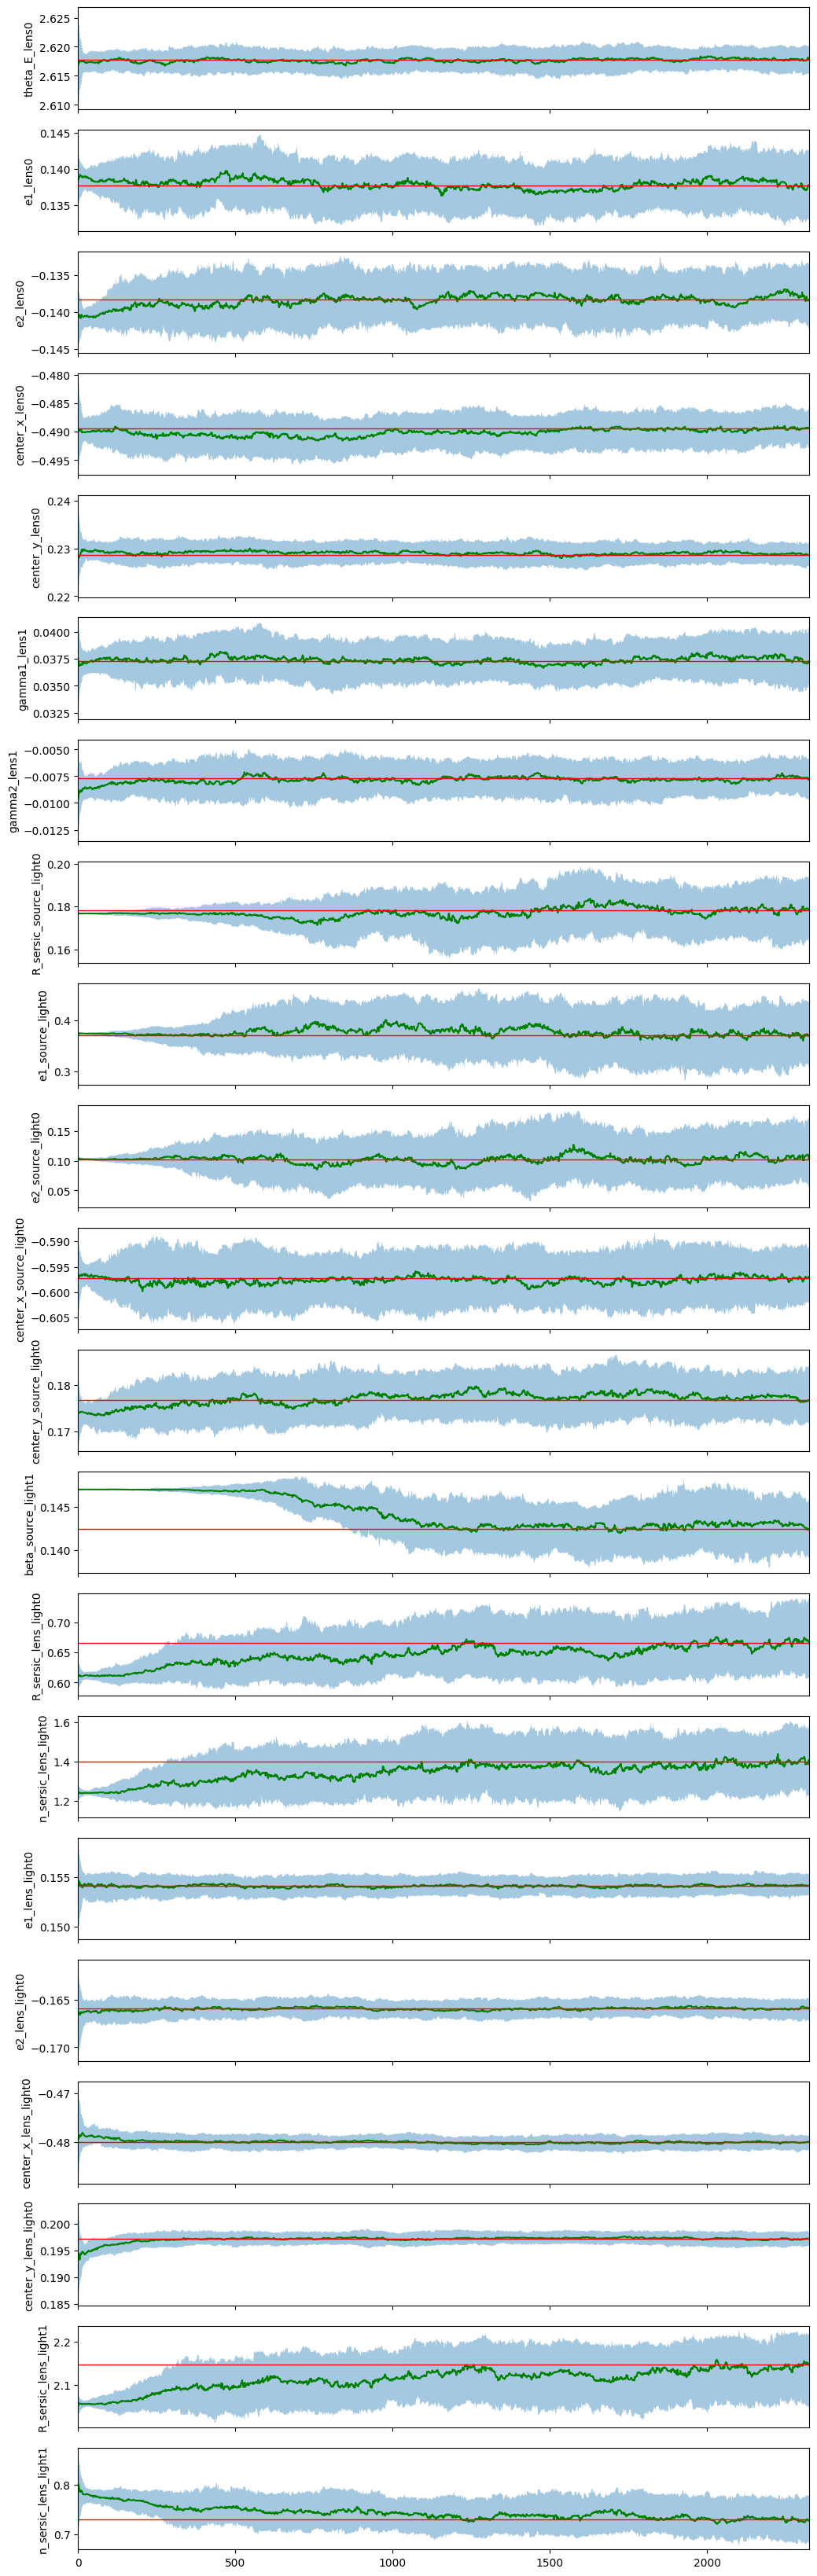

In [303]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 100
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

Number of non-linear parameters in the MCMC process: 21
Parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1']
Number of evaluations in the MCMC process: 232500
232500
Shape of samples_mcmc_cut: (3300, 21)


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_16685/4060837637.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


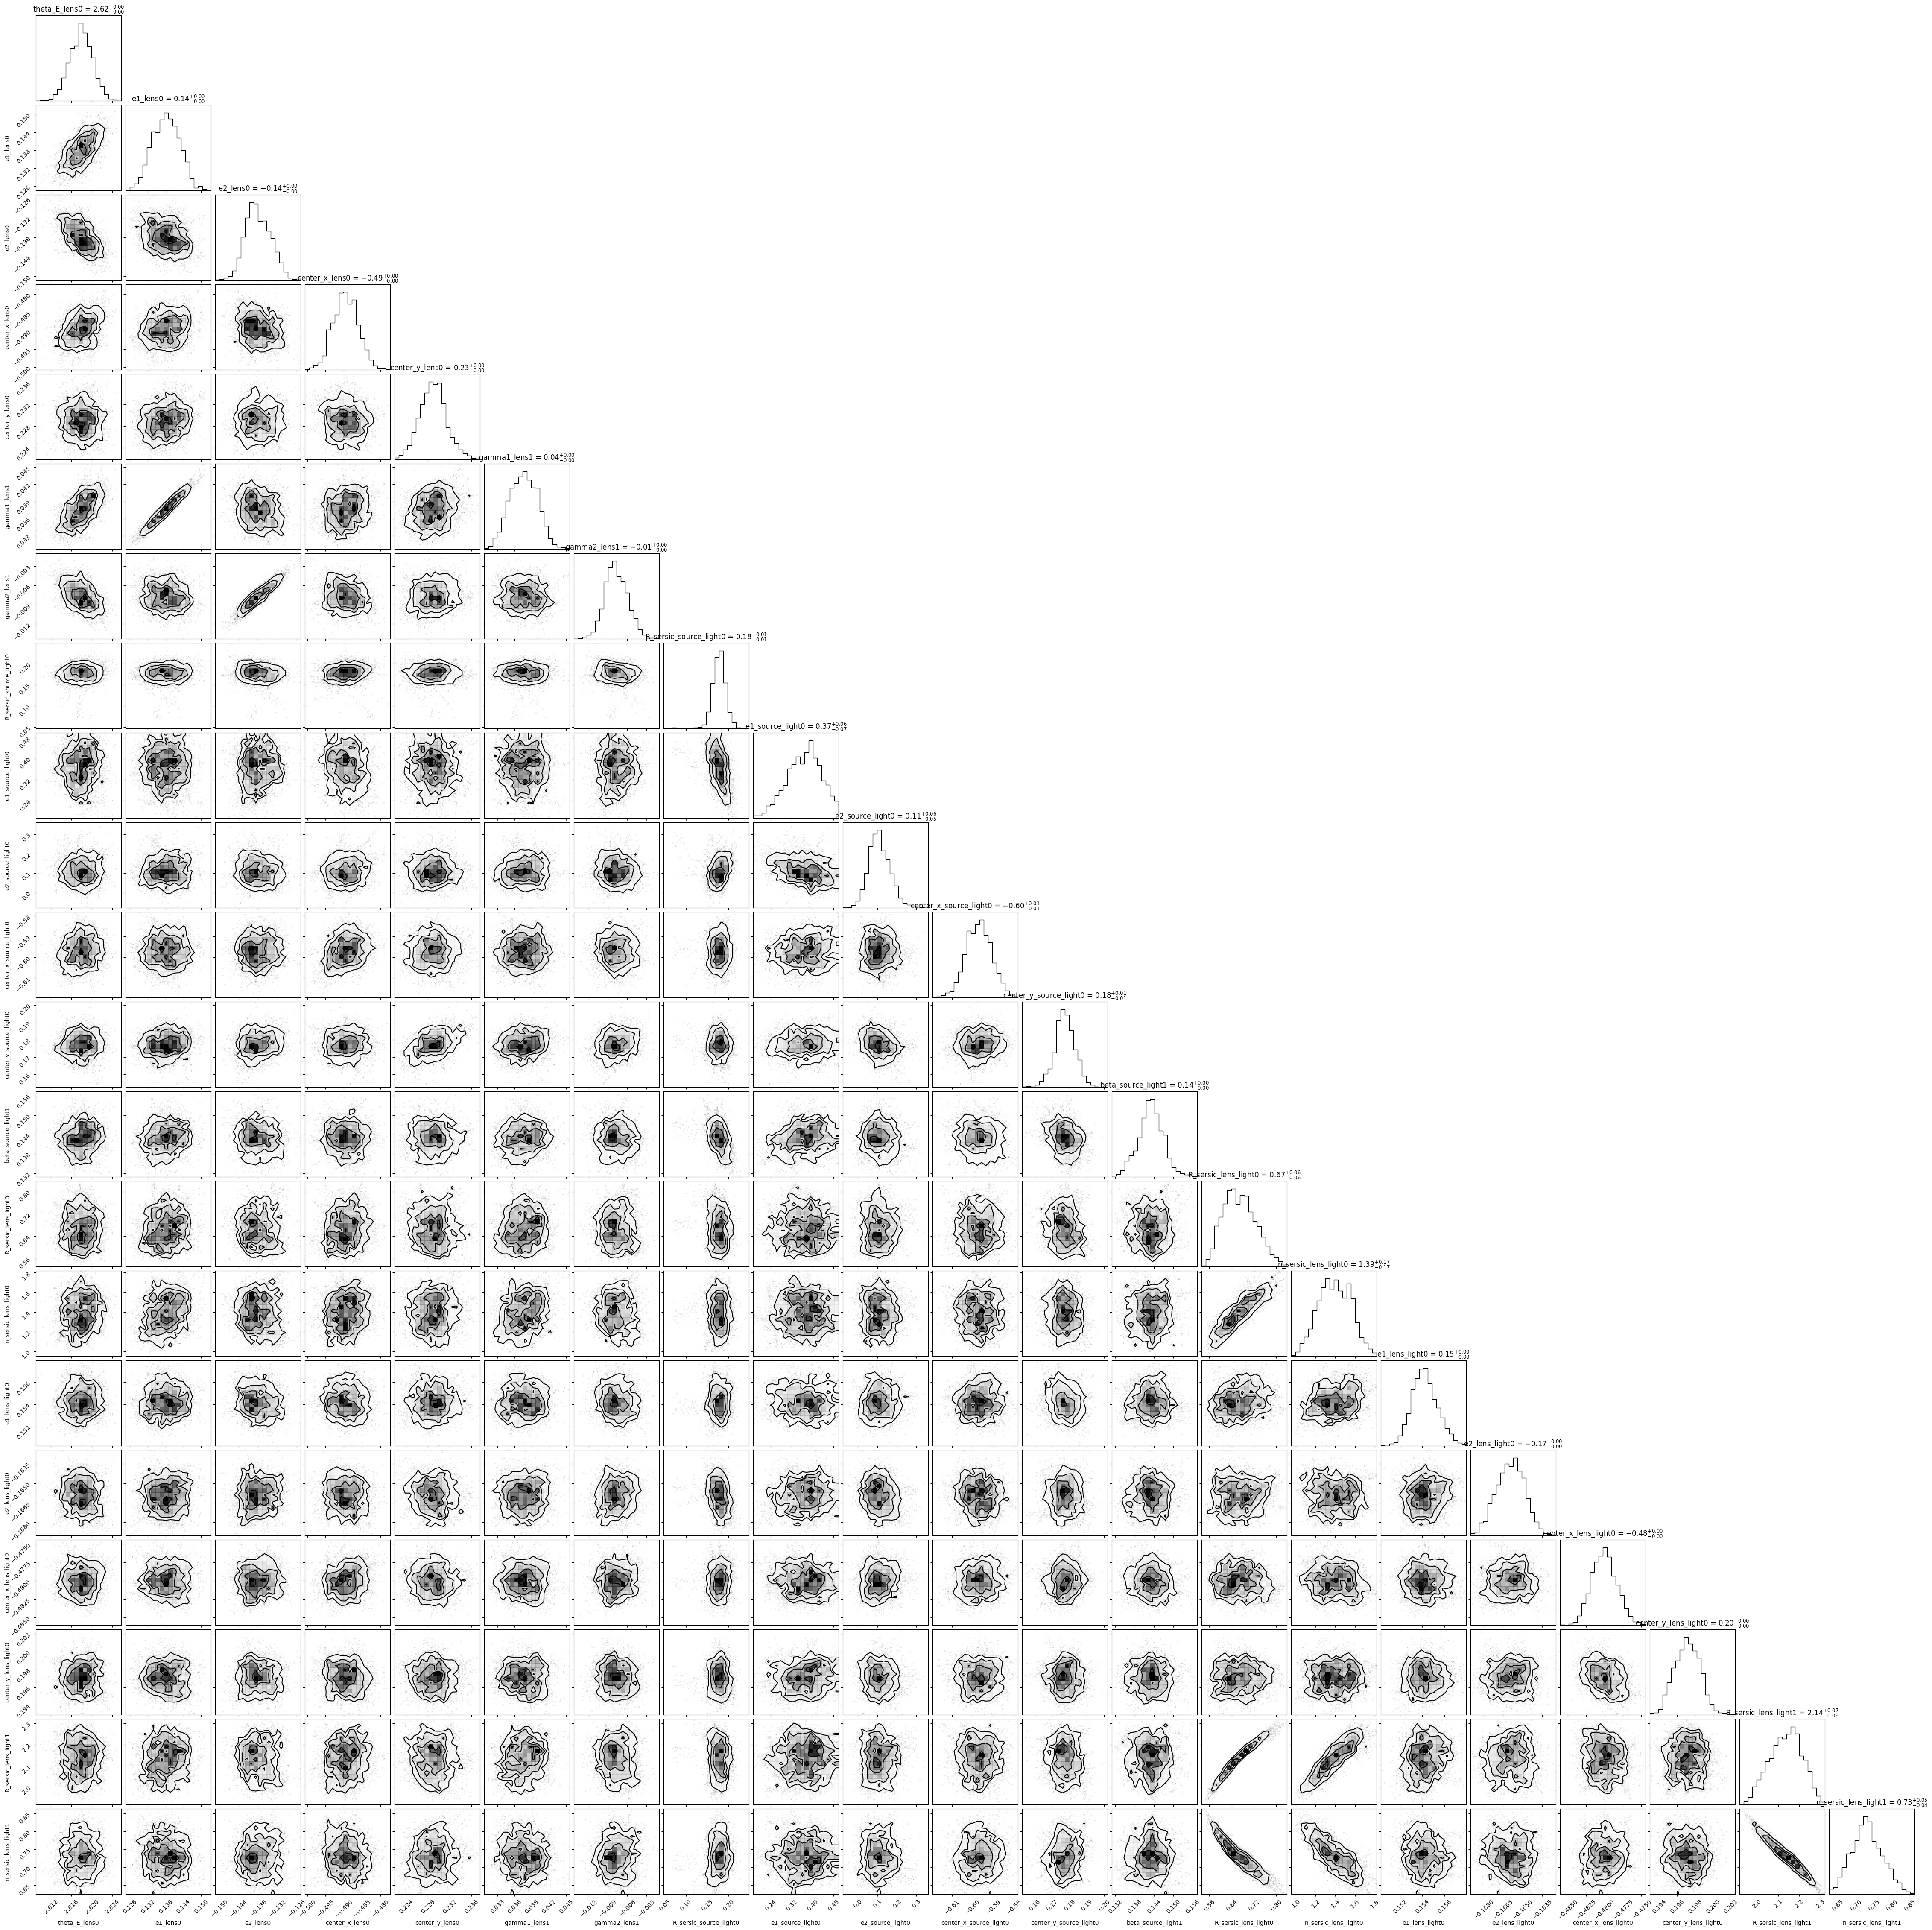

In [304]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2000
        thin = 10
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

-0.6943864653445287 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6943864653445152


/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


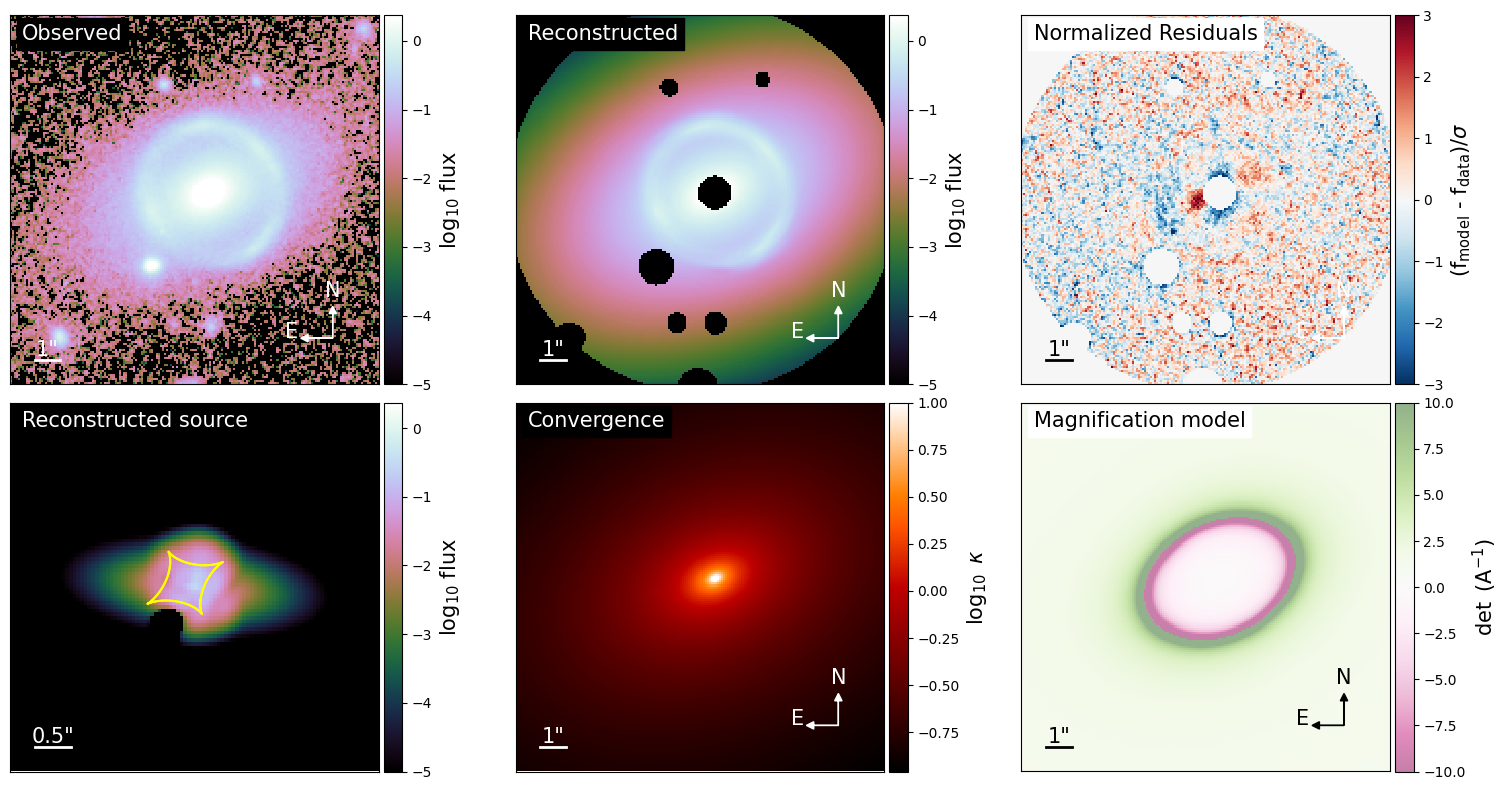

/Users/rafee_adnan/envs/bdlensing/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


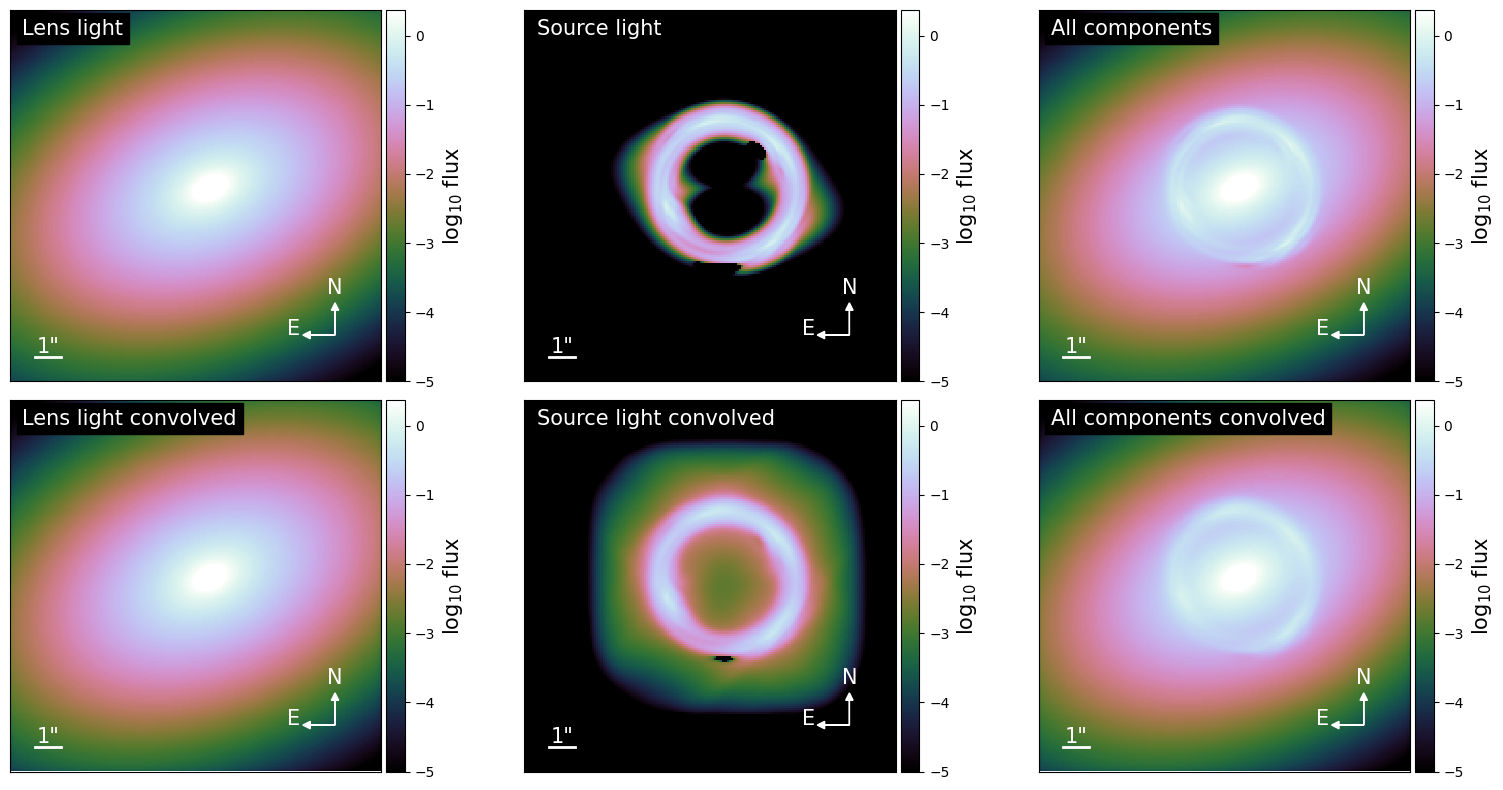

{'kwargs_lens': [{'theta_E': 2.616933298166673, 'gamma': 2.0, 'e1': 0.13498445689861893, 'e2': -0.13799701734717623, 'center_x': -0.48919780000337876, 'center_y': 0.22724729714513697}, {'gamma1': 0.03581324553509388, 'gamma2': -0.007614505340221305, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 27.472808454880248, 'R_sersic': 0.17905811105375463, 'n_sersic': 1.0, 'e1': 0.4405900752874344, 'e2': 0.08618760167772253, 'center_x': -0.5938132637385539, 'center_y': 0.17439386943621615}, {'amp': array([ 69.65526942, -28.24134825,  23.04133102,  15.12694505,
       -19.52308699,  90.72111116,  -2.23843532,  -7.49467114,
        -6.48084886,   4.52693401,  16.61730958,  -8.48262519,
        26.21225084,   7.5662991 ,   3.42438556,  -8.14065497,
         9.29079328,   4.45238508,   7.16102517, -10.21381648,
         7.88297566,  -6.06801279,  -9.88829022,   3.30278075,
         5.80341619,  -0.31623439,   3.07373117,  21.20029648,
         9.09251294,  -3.67585309,  -7.79117397,   4.4340350

In [305]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

In [308]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 2230
    thin = 10
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)

output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "DESIJ1101-0602_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Number of evaluations in the MCMC process: 232500
232500
Shape of shortened_samples_mcmc: (1000, 21)


In [310]:
lens_central_model_list = [lens_light_model_list[0], lens_light_model_list[1]]

light_model_central = LightModel(lens_central_model_list)
analysis_central = LightProfileAnalysis(light_model_central)

# Providing the lens light results from MCMC
kwargs_central_light = [
    kwargs_result_mcmc["kwargs_lens_light"][0],
    kwargs_result_mcmc["kwargs_lens_light"][1],
]

# Calculate the half-light radius of central lens
half_light_radius_mcmc = analysis_central.half_light_radius(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)
# Calculate the total flux of central lens
total_flux_central_mcmc = analysis_central.flux_components(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)

print("Half-light radius:", half_light_radius_mcmc)
print("Total Central lens flux:", total_flux_central_mcmc)

Half-light radius: 1.3280313878820786
Total Central lens flux: ([1124.619925049783, 1649.2745976511758], [0.6357597069648249, 2.048559055775547])


## Light and Mass ellipticity check after MCMC

In [311]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.6763914056283363,
light_q: 0.6302907705722193


## Mass and Light's Ellipticity of the Lens Galaxy + Shear

In [312]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

result_mass_gamma1 = kwargs_result_mcmc["kwargs_lens"][1]["gamma1"]
result_mass_gamma2 = kwargs_result_mcmc["kwargs_lens"][1]["gamma2"]

phi_mass, q_mass = ellipticity2phi_q(result_mass_e1, result_mass_e2)
phi_light, q_light = ellipticity2phi_q(result_light_e1, result_light_e2)
phi_shear, gamma_shear = shear_cartesian2polar(result_mass_gamma1, result_mass_gamma2)

print("phi_mass: {}, q_mass: {}".format(phi_mass, q_mass))

print("phi_light: {}, q_light: {}".format(phi_light, q_light))

print("phi_shear: {}, gamma_shear: {}".format(phi_shear, gamma_shear))

phi_mass: -0.3982167421328568, q_mass: 0.6763914056283363
phi_light: -0.4110578200636705, q_light: 0.6302907705722193
phi_shear: -0.1047486745067727, gamma_shear: 0.036613784935911504


## Convert and Store the Uncertainty of the parameters

In [313]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}

# renaming parameters
parameter_values["theta_E"] = parameter_values.pop("theta_E_lens0")
parameter_values["gamma"] = parameter_values.pop("gamma_lens0")
parameter_values["center_x_mass"] = parameter_values.pop("center_x_lens0")
parameter_values["center_y_mass"] = parameter_values.pop("center_y_lens0")
parameter_values["center_x_light"] = parameter_values.pop("center_x_lens_light0")
parameter_values["center_y_light"] = parameter_values.pop("center_y_lens_light0")

parameter_values["gamma"] = 2  # value of gamma is kept fixed at 2.0 for the mcmc run

# adding Half-light Radius
parameter_values["R_eff_light"] = half_light_radius_mcmc

print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E': [2.6177687254792854, 0.0023665507254877483, 0.0023991510842980013], 'gamma': 2, 'center_x_mass': [-0.4894282136895256, 0.003710506253172763, 0.0031703901066623685], 'center_y_mass': [0.22880604723266185, 0.0024268116094950942, 0.0024594206593055445], 'center_x_light': [-0.4800830469153752, 0.001477657866552129, 0.0017080750313543946], 'center_y_light': [0.1971557292544064, 0.0014518486585159973, 0.0014430927066691746], 'R_eff_light': 1.3280313878820786}


In [314]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = ellipticity2phi_q(prior_samples[j][i], prior_samples[j][i + 1])
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = shear_cartesian2polar(prior_samples[k][i], prior_samples[k][i + 1])
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E': [2.6177687254792854, 0.0023665507254877483, 0.0023991510842980013], 'gamma': 2, 'center_x_mass': [-0.4894282136895256, 0.003710506253172763, 0.0031703901066623685], 'center_y_mass': [0.22880604723266185, 0.0024268116094950942, 0.0024594206593055445], 'center_x_light': [-0.4800830469153752, 0.001477657866552129, 0.0017080750313543946], 'center_y_light': [0.1971557292544064, 0.0014518486585159973, 0.0014430927066691746], 'R_eff_light': 1.3280313878820786, 'phi_mass': [-0.3915745546668806, 0.008050356215271504, 0.01141948020458089], 'q_mass': [0.6746455090908703, 0.006122755093253662, 0.00804729828400974], 'phi_shear': [-0.09883256100462795, 0.02395998854910046, 0.02667270153473897], 'gamma_shear': [0.038230328689120574, 0.0025913420606199083, 0.0027401096708327202], 'phi_light': [-0.4111419313019572, 0.002635047102442334, 0.0026596107345483455], 'q_light': [0.6306360350479552, 0.0013957807922510002, 0.0016421680930061022]}


## Creating YAML File

In [315]:
# marge parameter_values and environment_values
print(parameter_values)
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1101-0602_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

{'theta_E': [2.6177687254792854, 0.0023665507254877483, 0.0023991510842980013], 'gamma': 2, 'center_x_mass': [-0.4894282136895256, 0.003710506253172763, 0.0031703901066623685], 'center_y_mass': [0.22880604723266185, 0.0024268116094950942, 0.0024594206593055445], 'center_x_light': [-0.4800830469153752, 0.001477657866552129, 0.0017080750313543946], 'center_y_light': [0.1971557292544064, 0.0014518486585159973, 0.0014430927066691746], 'R_eff_light': 1.3280313878820786, 'phi_mass': [-0.3915745546668806, 0.008050356215271504, 0.01141948020458089], 'q_mass': [0.6746455090908703, 0.006122755093253662, 0.00804729828400974], 'phi_shear': [-0.09883256100462795, 0.02395998854910046, 0.02667270153473897], 'gamma_shear': [0.038230328689120574, 0.0025913420606199083, 0.0027401096708327202], 'phi_light': [-0.4111419313019572, 0.002635047102442334, 0.0026596107345483455], 'q_light': [0.6306360350479552, 0.0013957807922510002, 0.0016421680930061022]}
YAML file 'DESIJ1101-0602_point_estimates.yml' create